# Facial Recognition with Tensorflow and FaceNet

In [1]:
# https://github.com/davidsandberg/facenet/wiki

### Import libraries

In [38]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
import numpy as np
import argparse
import facenet
import lfw
import os
import sys
import math
from sklearn import metrics
from scipy.optimize import brentq
from scipy import interpolate
import pickle
from sklearn.svm import SVC
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline


### Training and classifying code

In [65]:
class WrongAnswer():
    def __init__(self, predicted, actual, test_filepath, train_dirpath, actual_dirpath):
        self.predicted = predicted
        self.predicted_name = os.path.basename(train_dirpath)
        self.actual = actual
        self.actual_name = os.path.basename(actual_dirpath)
        self.test_filepath = test_filepath
        self.train_dirpath = train_dirpath
        self.actual_dirpath = actual_dirpath

In [69]:
def classifier(mode, # = 'CLASSIFY', 
               data_dir, # = '../data/subset/train', 
               classifier_filename, # = '../data/subset/subset_classifier.pkl', 
               model = '../data/models/20170512-110547.pb', 
               use_split_dataset = False, 
               test_data_dir = '../data/subset/test', 
               batch_size=90, 
               image_size=160, 
               seed=666, 
               min_nrof_images_per_class=20, 
               nrof_train_images_per_class=10):
  
    with tf.Graph().as_default():
      
        with tf.Session() as sess:
            
            np.random.seed(seed=seed)
            
            if use_split_dataset:
                dataset_tmp = facenet.get_dataset(data_dir)
                train_set, test_set = split_dataset(dataset_tmp, min_nrof_images_per_class, nrof_train_images_per_class)
                if (mode=='TRAIN'):
                    dataset = train_set
                elif (mode=='CLASSIFY'):
                    dataset = test_set
            else:
                dataset = facenet.get_dataset(data_dir)

            # Check that there are at least one training image per class
            for cls in dataset:
                assert(len(cls.image_paths)>0, 'There must be at least one image for each class in the dataset')            

            wrong_list = []
            paths, labels = facenet.get_image_paths_and_labels(dataset)
            
            print('Number of classes: %d' % len(dataset))
            print('Number of images: %d' % len(paths))
            
            # Load the model
            print('Loading feature extraction model')
            facenet.load_model(model)
            
            # Get input and output tensors
            images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
            embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
            embedding_size = embeddings.get_shape()[1]
            
            # Run forward pass to calculate embeddings
            print('Calculating features for images')
            nrof_images = len(paths)
            nrof_batches_per_epoch = int(math.ceil(1.0*nrof_images / batch_size))
            emb_array = np.zeros((nrof_images, embedding_size))
            for i in range(nrof_batches_per_epoch):
                start_index = i*batch_size
                end_index = min((i+1)*batch_size, nrof_images)
                paths_batch = paths[start_index:end_index]
                images = facenet.load_data(paths_batch, False, False, image_size)
                feed_dict = { images_placeholder:images, phase_train_placeholder:False }
                emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)
            
            classifier_filename_exp = os.path.expanduser(classifier_filename)

            if (mode=='TRAIN'):
                # Train classifier
                print('Training classifier')
                model = SVC(kernel='linear', probability=True)
                model.fit(emb_array, labels)
            
                # Create a list of class names
                class_names = [ cls.name.replace('_', ' ') for cls in dataset]

                # Saving classifier model
                with open(classifier_filename_exp, 'wb') as outfile:
                    pickle.dump((model, class_names), outfile)
                print('Saved classifier model to file "%s"' % classifier_filename_exp)
                
            elif (mode=='CLASSIFY'):
                # Classify images
                print('Testing classifier')
                with open(classifier_filename_exp, 'rb') as infile:
                    (model, class_names) = pickle.load(infile)

                print('Loaded classifier model from file "%s"' % classifier_filename_exp)

                predictions = model.predict_proba(emb_array)
                best_class_indices = np.argmax(predictions, axis=1)
                best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
                
                for i in range(len(best_class_indices)):
                    msg = "WRONG!!!"
                    
                    if np.equal(best_class_indices[i], labels[i]):
                        msg = "Correct"
                    else:
                        wrong = WrongAnswer(best_class_indices[i], 
                                            labels[i], 
                                            paths[i], 
                                            os.path.dirname(paths[best_class_indices[i]]),
                                            os.path.dirname(paths[i])
                                           )
                        wrong_list.append(wrong)
                        
                    print("\nReading " + os.path.basename(paths[i]) + "... " + msg)

                    print('%4d  %s: %.3f' % (i, class_names[best_class_indices[i]], best_class_probabilities[i]))

                    
                accuracy = np.mean(np.equal(best_class_indices, labels))
                print('\nAccuracy: %.3f' % accuracy)
                
    return wrong_list
                
            
def split_dataset(dataset, min_nrof_images_per_class, nrof_train_images_per_class):
    train_set = []
    test_set = []
    for cls in dataset:
        paths = cls.image_paths
        # Remove classes with less than min_nrof_images_per_class
        if len(paths)>=min_nrof_images_per_class:
            np.random.shuffle(paths)
            train_set.append(facenet.ImageClass(cls.name, paths[:nrof_train_images_per_class]))
            test_set.append(facenet.ImageClass(cls.name, paths[nrof_train_images_per_class:]))
    return train_set, test_set

<ipython-input-69-f3a23df1f403>:31: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(cls.image_paths)>0, 'There must be at least one image for each class in the dataset')


### Simple test with 9 people

In [33]:
classifier(mode = "TRAIN", 
           data_dir = '../data/subset_small/train', 
           classifier_filename = '../data/subset_small/subset_classifier.pkl')

Number of classes: 9
Number of images: 18
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Training classifier
Saved classifier model to file "../data/subset_small/subset_classifier.pkl"


In [57]:
wrongs = classifier(mode = 'CLASSIFY', 
           data_dir = '../data/subset_small/test', 
           classifier_filename = '../data/subset_small/subset_classifier.pkl')

Number of classes: 9
Number of images: 9
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Testing classifier
Loaded classifier model from file "../data/subset_small/subset_classifier.pkl"

Reading Al_Pacino_0003.png... Correct
   0  Al Pacino: 0.215

Reading Ben_Affleck_0007.png... Correct
   1  Ben Affleck: 0.214

Reading Britney_Spears_0014.png... Correct
   2  Britney Spears: 0.221

Reading Halle_Berry_0016.png... Correct
   3  Halle Berry: 0.279

Reading Harbhajan_Singh_0002.png... Correct
   4  Harbhajan Singh: 0.329

Reading Oprah_Winfrey_0004.png... Correct
   5  Oprah Winfrey: 0.207

Reading Will_Smith_0002.png... Correct
   6  Will Smith: 0.247

Reading Winona_Ryder_0024.png... Correct
   7  Winona Ryder: 0.212

Reading Yao_Ming_0008.png... Correct
   8  Yao Ming: 0.276

Accuracy: 1.000


In [58]:
print(wrongs)

[]


### Bigger test with 100 people

In [51]:
classifier(mode = "TRAIN", 
           data_dir = '../data/newdir_train2_test1/train', 
           classifier_filename = '../data/newdir_train2_test1/classifier.pkl')


Number of classes: 100
Number of images: 200
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Training classifier
Saved classifier model to file "../data/newdir_train2_test1/classifier.pkl"


[]

In [70]:
wrongs = classifier(mode = 'CLASSIFY', 
           data_dir = '../data/newdir_train2_test1/test', 
           classifier_filename = '../data/newdir_train2_test1/classifier.pkl')


Number of classes: 100
Number of images: 100
Loading feature extraction model
Model filename: ../data/models/20170512-110547.pb
Calculating features for images
Testing classifier
Loaded classifier model from file "../data/newdir_train2_test1/classifier.pkl"

Reading Aaron_Peirsol_0003.png... Correct
   0  Aaron Peirsol: 0.040

Reading Abdoulaye_Wade_0003.png... Correct
   1  Abdoulaye Wade: 0.040

Reading Abdullah_0003.png... Correct
   2  Abdullah: 0.036

Reading Abdullah_Gul_0003.png... Correct
   3  Abdullah Gul: 0.029

Reading Abdullah_al-Attiyah_0003.png... Correct
   4  Abdullah al-Attiyah: 0.030

Reading Abel_Pacheco_0003.png... Correct
   5  Abel Pacheco: 0.024

Reading Abid_Hamid_Mahmud_Al-Tikriti_0003.png... Correct
   6  Abid Hamid Mahmud Al-Tikriti: 0.026

Reading Adam_Sandler_0003.png... Correct
   7  Adam Sandler: 0.023

Reading Adel_Al-Jubeir_0003.png... Correct
   8  Adel Al-Jubeir: 0.039

Reading Adolfo_Aguilar_Zinser_0003.png... Correct
   9  Adolfo Aguilar Zinser: 0.


Predicted: 20 (Alastair_Campbell), Actual: 15 (Akhmed_Zakayev)
../data/newdir_train2_test1/test\Akhmed_Zakayev\Akhmed_Zakayev_0003.png
../data/newdir_train2_test1/test\Alastair_Campbell
../data/newdir_train2_test1/test\Akhmed_Zakayev

Predicted: 3 (Abdullah_Gul), Actual: 23 (Alejandro_Avila)
../data/newdir_train2_test1/test\Alejandro_Avila\Alejandro_Avila_0003.png
../data/newdir_train2_test1/test\Abdullah_Gul
../data/newdir_train2_test1/test\Alejandro_Avila

Predicted: 71 (Arturo_Gatti), Actual: 24 (Alejandro_Toledo)
../data/newdir_train2_test1/test\Alejandro_Toledo\Alejandro_Toledo_0003.png
../data/newdir_train2_test1/test\Arturo_Gatti
../data/newdir_train2_test1/test\Alejandro_Toledo

Predicted: 65 (Arlen_Specter), Actual: 33 (Alvaro_Noboa)
../data/newdir_train2_test1/test\Alvaro_Noboa\Alvaro_Noboa_0003.png
../data/newdir_train2_test1/test\Arlen_Specter
../data/newdir_train2_test1/test\Alvaro_Noboa

Predicted: 53 (Ann_Veneman), Actual: 41 (Ana_Palacio)
../data/newdir_train2_test1/te

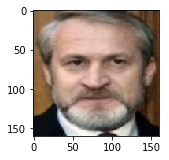

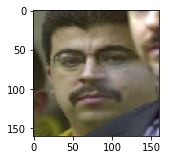

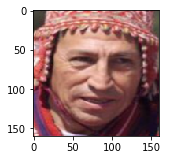

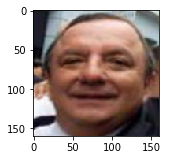

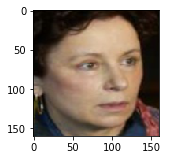

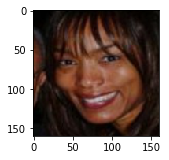

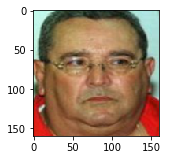

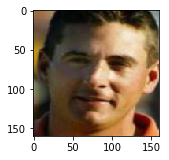

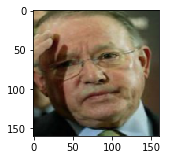

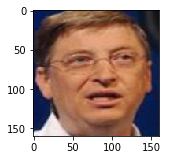

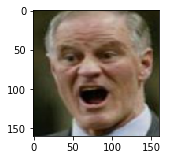

In [106]:
i = 0

for wrong in wrongs:
    print("\nPredicted:", wrong.predicted, "(" + wrong.predicted_name + "), Actual:", wrong.actual, "(" + wrong.actual_name + ")")
    print(wrong.test_filepath)
    print(wrong.train_dirpath)
    print(wrong.actual_dirpath)
#     fig, ax = plt.subplots(1,2)
#     sns.countplot(df['batting'], ax=ax[0])
#     sns.countplot(df['bowling'], ax=ax[1])
#     fig.show()
    pil_im = Image.open(wrong.test_filepath, 'r')
    plt.figure(figsize=(30, 30))
    plt.subplot(11,2,i+1)
    
    plt.imshow(np.asarray(pil_im))
    i += 1
                    